# Imports

In [21]:
import os
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

from model_evaluation import *

# Data Settings

In [19]:
# All bird species available in the HDF5 spectrogram dataset
ALL_BIRD_SPECIES = [
    'amecro',  # American Crow
    'amerob',  # American Robin
    'bewwre',  # Bewick's Wren
    'bkcchi',  # Black-capped Chickadee
    'daejun',  # Dark-eyed Junco
    'houfin',  # House Finch
    'houspa',  # House Sparrow
    'norfli',  # Northern Flicker
    'rewbla',  # Red-winged Blackbird
    'sonspa',  # Song Sparrow
    'spotow',  # Spotted Towhee
    'whcspa',  # White-crowned Sparrow
]

# Selected bird species for binary classification
# Class 0: 'houspa' → House Sparrow
# Class 1: 'sonspa' → Song Sparrow
SELECTED_BIRD_CLASSES = [
    'houspa',  # Class 0
    'sonspa',  # Class 1
]

# Path to the HDF5 file containing bird spectrograms
SPEC_FILE_PATH = Path('../data/bird_spectrograms.hdf5')

# Training hyperparameters
EPOCHS = 50                 # Total number of training epochs
NUM_CV_FOLDS = 3            # K-Fold cross-validation (choose 3, 4, or 5)
BATCH_SIZE = 32             # Batch size for training
LEARNING_RATE = 0.0005      # Learning rate for the optimizer

# List of evaluation metrics returned by `evaluate()` function
EVALUATION_METRICS = [
    "Weighted Accuracy", "Sensitivity/Recall", "Specificity",
    "Precision_class0", "Precision_class1", "Precision_avg",
    "F1_class0", "F1_class1", "F1_avg", "auc_roc_score",
    "False_Discovery_Rate", "False_Negative_Rate",
    "False_Omission_Rate", "False_Positive_Rate", "Jaccard"
]

# Load Data
We need to transpose the data from (128, 517, sample_size) into (sample_size, 128, 517) because CNNs expect an input of shape (N, C, H, W). 

Here:
- N = number of samples
- C = number of channels (1 for grayscale spectrograms)
- H = height (128)
- W = width (517)

In [17]:
X = []
y = []

label_map = {'houspa': 1, 'sonspa': 0} # 1 for houspa, 0 for sonspa

with h5py.File(SPEC_FILE_PATH, 'r') as f:
    for key in SELECTED_BIRD_CLASSES:
        data = f[key][:]  # shape = (128, 517, N)
        data = np.transpose(data, (2, 0, 1))  # shape = (N, 128, 517)
        X.append(data)
        y.append(np.full(data.shape[0], label_map[key]))  

X = np.concatenate(X, axis=0)  # (N_total, 128, 517)
y = np.concatenate(y)

# Data shape prep for tensorflow
X = np.expand_dims(X, axis=-1)  # (N, 128, 517, 1)
y = np.expand_dims(y, axis=-1)  # (N, 1)

# CNN Model Model Architecture

This convolutional neural network (CNN) performs **binary classification** on spectrogram inputs of shape `(1, 128, 517)`, where:
- `1` is the channel dimension (grayscale),
- `128` is the number of frequency bins (height),
- `517` is the number of time steps (width).

---

### General Steps for CNN
According to a very long discussion on the order of layers, BN, DropOut, and Pooling on [stackoverflow](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) <br>
Generally, this laying is the consensus. <br>

Conv → BatchNorm → ReLU → Dropout → MaxPool

# CNN Model #1

In [8]:
def build_bird_binary_cnn_v1(input_shape=(128, 517, 1), dropout_rate=0.2, learning_rate=0.0001):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1)(x)  # No activation, use from_logits=True

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
    return model

# CNN Model #2

In [ ]:
class BirdBinaryCNN_v2(tf.keras.Model):
    def __init__(self, input_channels=1, dropout_rate=0.2):
        """
        A CNN with 4 convolutional layers for binary classification using global average pooling,
        batch normalization, and dropout after each layer.

        Args:
            input_channels: Number of input channels (e.g., 1 for grayscale)
            dropout_rate: Dropout probability
        """
        super(BirdBinaryCNN_v2, self).__init__()

        self.conv1 = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)
        self.pool1 = layers.MaxPooling2D(pool_size=2, strides=2)

        self.conv2 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(dropout_rate)
        self.pool2 = layers.MaxPooling2D(pool_size=2, strides=2)

        self.conv3 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')
        self.bn3 = layers.BatchNormalization()
        self.dropout3 = layers.Dropout(dropout_rate)
        self.pool3 = layers.MaxPooling2D(pool_size=2, strides=2)

        self.conv4 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(dropout_rate)

        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dropout5 = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(1)  # From_logits=True will be used in loss

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout1(x, training=training)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout2(x, training=training)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout3(x, training=training)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout4(x, training=training)

        x = self.global_avg_pool(x)
        x = self.dropout5(x, training=training)
        x = self.fc(x)  # No sigmoid here; use BinaryCrossentropy(from_logits=True)

        return x


# Graph Plotting

In [6]:
def build_plot_training_history(history):
    """
    Plots training and validation accuracy and loss from two training histories.

    Args:
        history: First training history object.
        history2: Second training history object.
    """
    # Extract values from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    # Plot Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

# Model Training and Evaluation Loop

For CNNs, these four essential steps are important. <br>
I have explained more about backpropagation in this [Medium article](https://medium.com/data-science-collective/why-backpropagation-is-so-important-for-models-in-machine-learning-4736591b24b3)

- Forward pass: Feed input through the network to make a prediction.
- Loss calculation: It compares those predictions to the actual labels and computes the loss.
- Backpropagation: Use the chain rule to find how much each weight influenced the loss.
- Weight update: Apply the gradients using an optimizer like Adam.
---

## Reasoning behind of KFold Cross Validation
Since the dataset is relatively small, it may be best to go with just a KFold Cross Validation rather than doing a train-test split + cross-validation. <br>

That is the reason why I went with K-fold cross validation.

---

# First Model Run (2 Layer Model)
- 3 FOLD (non-stratified)
- Batch Size = 32
- Dropout = 0.2
- Learning Rate = 0.0005
- 50 EPOCHS with early stopping.


Fold 1 | Train size: 595, Test size: 298
(128, 517, 1)
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5412 - loss: 4.7580 - val_accuracy: 0.2651 - val_loss: 11.8452 - learning_rate: 5.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5621 - loss: 4.3761 - val_accuracy: 0.7349 - val_loss: 4.2263 - learning_rate: 5.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6314 - loss: 2.6210 - val_accuracy: 0.7349 - val_loss: 4.2263 - learning_rate: 5.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5326 - loss: 3.2902 - val_accuracy: 0.7349 - val_loss: 2.5204 - learning_rate: 5.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6107 - loss: 3.1599 - val_accuracy: 0.7315 - val_loss: 3.7630 - learning_rate: 5.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6269 - loss: 3.3647 - val_accuracy: 0.7148 - val_loss: 2.7299 - learning_rate: 5.0000e-04
Epoch 7/50
19/19 ━━

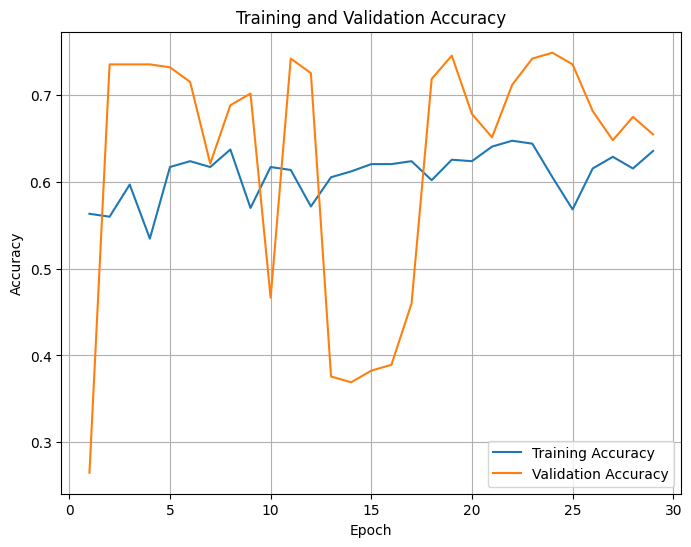

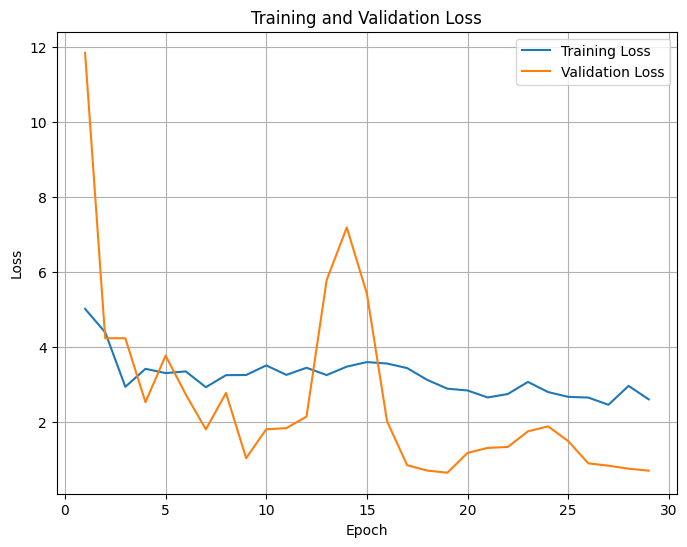

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
[[  4  75]
 [  1 218]]

Fold 2 | Train size: 595, Test size: 298
(128, 517, 1)
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5424 - loss: 3.6701 - val_accuracy: 0.7181 - val_loss: 4.4938 - learning_rate: 5.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5557 - loss: 5.3097 - val_accuracy: 0.7181 - val_loss: 4.4486 - learning_rate: 5.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6425 - loss: 3.8138 - val_accuracy: 0.2987 - val_loss: 6.5049 - learning_rate: 5.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6353 - loss: 4.8940 - val_accuracy: 0.3087 - val_loss: 8.8744 - learning_rate: 5.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6414 - loss: 4.6322 - val_accuracy: 0.3356 - val_loss: 8.3372 - learning_rate: 5.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6466 - loss: 4.3475 - val_accuracy: 0.6242 - v

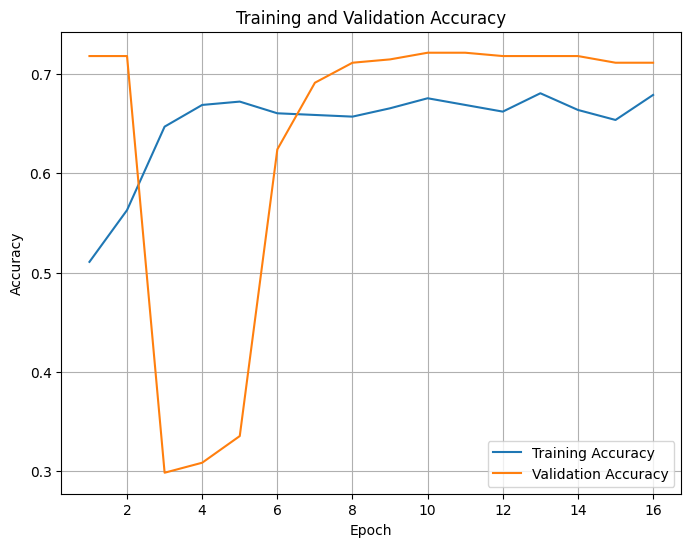

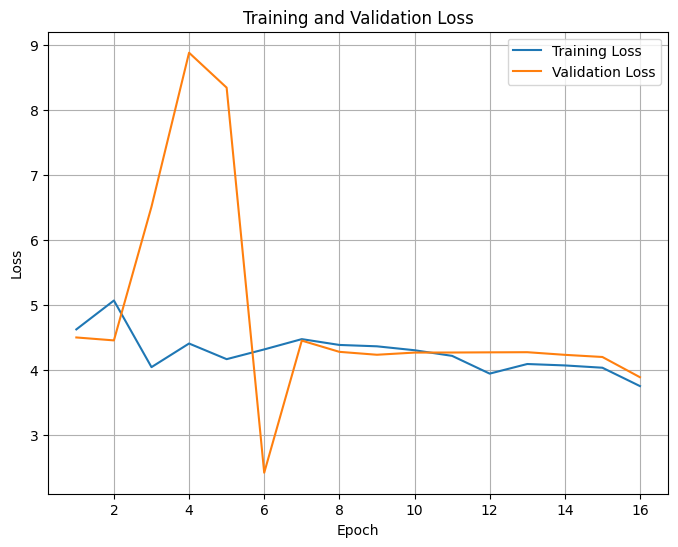

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
[[  9  77]
 [ 37 175]]

Fold 3 | Train size: 596, Test size: 297
(128, 517, 1)
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6098 - loss: 3.6147 - val_accuracy: 0.6667 - val_loss: 5.3147 - learning_rate: 5.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6561 - loss: 3.4865 - val_accuracy: 0.5556 - val_loss: 1.4985 - learning_rate: 5.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5610 - loss: 4.8801 - val_accuracy: 0.6700 - val_loss: 5.2630 - learning_rate: 5.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6334 - loss: 2.7551 - val_accuracy: 0.6667 - val_loss: 5.2687 - learning_rate: 5.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5981 - loss: 3.1428 - val_accuracy: 0.6667 - val_loss: 5.0438 - learning_rate: 5.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6491 - loss: 2.9898 - val_accuracy: 0.6465 - v

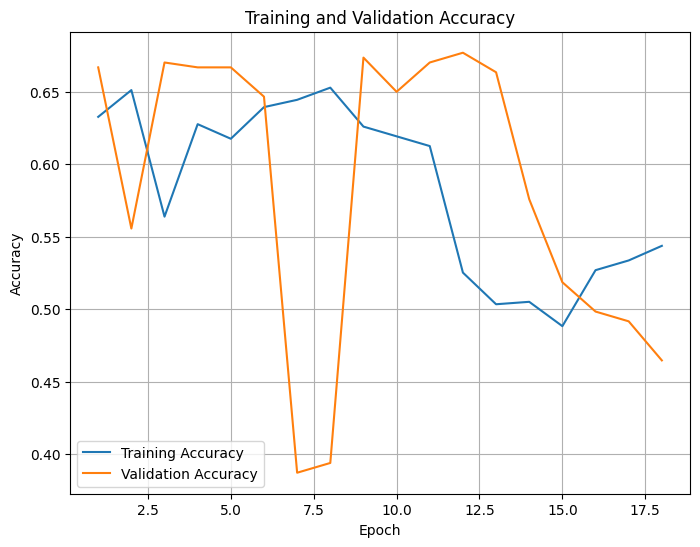

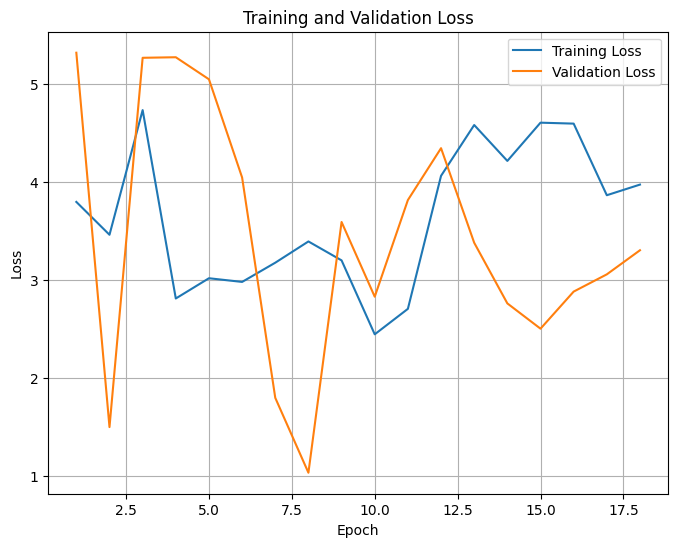

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step
[[ 72  26]
 [154  45]]


In [ ]:
# K-Fold CV
kfold = KFold(n_splits=NUM_CV_FOLDS, shuffle=True, random_state=42)
metrics = pd.DataFrame(columns=EVALUATION_METRICS)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1} | Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape[1:])
    # Initialize model
    model = build_bird_binary_cnn_v1(input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=LEARNING_RATE)

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Optional: Training history visualization
    build_plot_training_history(history)

    # Evaluate
    evaluator = BinaryEvaluation(model)
    results, confusion_matrix = evaluator.model_test(X_test, y_test)
    print(confusion_matrix)

    # Save metrics
    VERSION_TAG = f"../output/binary_model_{EPOCHS}_fold_{fold + 1}"
    metrics.loc[VERSION_TAG] = list(results)
    single_result_df = pd.DataFrame(metrics.loc[[VERSION_TAG]])

    output_path = f"../output/binary_model_{EPOCHS}_{BATCH_SIZE}_{LEARNING_RATE}_student_evaluation_results.csv"
    single_result_df.to_csv(output_path, mode="a", header=not os.path.isfile(output_path))

    # Cleanup
    K.clear_session()
    del model
    gc.collect()

In [ ]:
# K-Fold CV
kfold = StratifiedKFold(n_splits=NUM_CV_FOLDS, shuffle=True, random_state=42)
metrics = pd.DataFrame(columns=EVALUATION_METRICS)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\nFold {fold + 1} | Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(X_train.shape[1:])
    # Initialize model
    model = build_bird_binary_cnn_v1(input_shape=X_train.shape[1:], dropout_rate=0.2, learning_rate=LEARNING_RATE)

    # Callbacks
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Optional: Training history visualization
    build_plot_training_history(history)

    # Evaluate
    evaluator = BinaryEvaluation(model)
    results, confusion_matrix = evaluator.model_test(X_test, y_test)
    print(confusion_matrix)

    # Save metrics
    VERSION_TAG = f"../output/binary_model_{EPOCHS}_fold_{fold + 1}"
    metrics.loc[VERSION_TAG] = list(results)
    single_result_df = pd.DataFrame(metrics.loc[[VERSION_TAG]])

    output_path = f"../output/binary_model_{EPOCHS}_{BATCH_SIZE}_{LEARNING_RATE}_student_evaluation_results.csv"
    single_result_df.to_csv(output_path, mode="a", header=not os.path.isfile(output_path))

    # Cleanup
    K.clear_session()
    del model
    gc.collect()